<a href="https://colab.research.google.com/github/AlyShmahell/WeirdTargets/blob/master/weirdtargets2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [3]:
! pip install ujson==4.0.1 numpy==1.18.5 pandas==1.1.5 tqdm==4.41.1 toolz==0.11.1 statsmodels==0.10.2

     |████████████████████████████████| 184kB 8.2MB/s 
     |████████████████████████████████| 20.1MB 1.2MB/s 
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.18.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5


In [17]:
import os
import gc
import sys
import ujson
import psutil
import requests
import itertools
import scipy
import numpy                   as     np
import pandas                  as     pd
import operator                as     op
import matplotlib.pyplot       as     plt
import statsmodels.formula.api as     smf
from   copy                    import copy
from   scipy.stats             import zscore, variation, probplot, pearsonr, shapiro
from   tqdm                    import tqdm
from   functools               import reduce
from   gzip                    import GzipFile
from   toolz                   import partition_all
from   pathlib                 import Path
from   concurrent.futures      import ProcessPoolExecutor
from   statsmodels.graphics.gofplots import qqplot
from   numba import cuda
plt.style.use('ggplot')
%matplotlib inline

# nCr

In [5]:
def ncr(n, r):
    r     = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return  numer / denom

# msuba

In [522]:
def maxsuba(s, t):
    mean    = np.mean(s)
    std     = np.std(s)
    zscores = (s - mean)/std
    r       = tick    = 0
    for tock, z in enumerate(zscores):
        zsum  = np.sum(zscores[tick:tock])
        if zsum*std+((tock-tick)*mean) <= t:
            r     = tock - tick
            tick += (zsum <= 0) * (tock-tick)
        print(z, zsum, tick, tock)
    return tock - tick

In [188]:
def minsuba(chunk_sizes, t_size):
    v, f = np.unique(chunk_sizes, return_counts=True)
    l    = len(chunk_sizes)
    p    = f/l
    n    = np.ceil(sum([(t_size*p[i])/(v[i]) for i in range(len(v))]))
    return int(n)

In [542]:
def maxsuba2(chunk_sizes, t_size):
    v, f = np.unique(chunk_sizes, return_counts=True)
    l    = len(chunk_sizes)
    p    = f/l
    print([(t_size*p[i])/(v[i]) for i in range(len(v))])
    n    = np.max([(t_size*p[i])/(v[i]) for i in range(len(v))])
    return n.round(0).astype(int)

In [577]:
def testsuba(s, t_size):
    def gather(a):
        for idx in range(len(a)):
            if sum(a[0:idx]) > t_size:
                return idx-1
        return len(a)-1
    def scan(sdx, jdx):
        for idx in range(sdx, len(s)):
            if sum(s[idx:idx+jdx]) > t_size:
                jdx = gather(s[idx:idx+jdx])
                sdx = idx - idx % max(jdx, 1)
                return scan(sdx, jdx)
        return jdx
    return scan(0, gather(s))


In [579]:
x = np.array([2,2,2, 2, 2,2,2])
#z = zscore(x)
print(testsuba(x,14))

6


# Downloader

In [9]:
def downloader(url):
    def func(r, path, filename, total_size, block_size):
        t          = tqdm(
            desc       = f"downloading {filename}",
            total      = total_size, 
            unit       = 'iB', 
            unit_scale = True
        )
        with open(path/filename, 'wb') as f:
            for data in r.iter_content(block_size):
                t.update(len(data))
                f.write(data)
        t.close()
        try:
            assert not(total_size != 0 and t.n != total_size)
        except:
            sys.exit(f"downloaded {t.n}/{total_size}", flush=True)
    r          = requests.get(url, stream=True)
    total_size = int(r.headers.get('content-length', 0))
    block_size = 1024**2
    filename   = url.split('/')[-1]
    path       = Path(Path.home())/Path('workspace')
    path.mkdir(parents=True, exist_ok=True)
    try:
        assert Path(path/filename).stat().st_size == total_size
        print(f"{filename} is already downloaded", flush=True)
    except:
        func(r, path, filename, total_size, block_size)
    filename    = filename.split('.')
    (filename, 
     extension) = ".".join(filename[:-1]), filename[-1]
    return path, filename, extension

# Probe

In [10]:
class Probe:
    def __init__(self, url):
        (self.path, 
         self.filename, 
         self.extension)   = downloader(url)
        self.chunk_sizes   = []
        with tqdm(desc=f"Feature Probing") as tqdmo:
            with GzipFile(f"{self.path}/{self.filename}.{self.extension}") as f:
                for b in f:
                    self.chunk_sizes += [33+len(b)]
                    tqdmo.update(1)
        with open('sizes.json', 'w') as f:
            ujson.dump(self.chunk_sizes, f)
        self.total_size = sum(self.chunk_sizes)

In [11]:
def digital_unique(data, return_counts=True):
    minim = int(np.floor(min(data)))
    maxim = int(np.floor(max(data)))
    bins = np.linspace(minim, maxim, maxim-minim)
    digitized = np.digitize(data, bins, True)
    bin_means = np.array([data[digitized == i].mean() for i in range(1, len(bins)+1)])
    bin_means = bin_means[np.where(~np.isnan(bin_means))[0]]
    v, f = np.unique(digitized, return_counts=True)
    v = bin_means
    return np.array(v),f

In [12]:
probe = Probe('https://storage.googleapis.com/open-targets-data-releases/17.12/17.12_evidence_data.json.gz')

downloading 17.12_evidence_data.json.gz: 100%|██████████| 5.43G/5.43G [02:34<00:00, 35.1MiB/s]
Feature Probing: 5784597it [02:39, 36163.68it/s]


In [13]:
def cv(s, t):
    return np.sqrt(sum([(x-t)**2 for x in s])/len(s))/t

In [21]:
print(minsuba(probe.chunk_sizes, int(os.statvfs('/').f_bsize*1024*8)))

7190


In [53]:
print(testsuba(probe.chunk_sizes, int(os.statvfs('/').f_bsize*1024*8)))

[0.3352311429264072, 0.3352311436725317, 0.3352311448451408, 0.3352311461245287, 0.3352311467642924]
5695


In [12]:
def test(probe, func):
    dic      = {'t_size':[], 'mean': [], 'cv': [], 'zscores': [], 'dist': []}
    iterable = range(1,14)
    with tqdm(desc=f'testing {func.__name__}', iterable=iterable) as tqdmo:
        for i in iterable:
            t_size = 2**i*1024**2
            tqdmo.set_postfix({'t_size': t_size})
            n      = func(probe.chunk_sizes, t_size)
            dist   = np.array([int(sum(probe.chunk_sizes[j:j+n])) for j in range(0,len(probe.chunk_sizes)-n,n)])
            dic['dist']   += [dist/1024**2]
            dic['t_size'] += [t_size/1024**2]
            dic['mean']   += [np.mean(dist)/1024**2]
            dic['cv']     += [{
                'size': 2**i,
                'cv': cv(dist/1024**2, 2**i)
            }]
            dic['zscores'] += [digital_unique(zscore(dist/1024**2), return_counts=True)]
            tqdmo.update(1)
    print(ujson.dumps({
        'pearson': pearsonr(dic['t_size'], dic['mean']),
        'cv': dic['cv']

    }, indent=4))
    fig, axs = plt.subplots(6,3)
    fig.set_size_inches(20, 12)
    fig.tight_layout(pad=4.0)
    axs[0][0].scatter(dic['t_size'], dic['t_size'], label='t_size')
    axs[0][0].plot(dic['t_size'],   dic['mean'],   label='mean')
    axs[0][0].set_title("Correlation")
    axs[0][0].set(xlabel="Expected", ylabel="Result")
    axs[0][0].legend()
    for i in range(3,len(dic['zscores'])+3):
            axs[i//3][i%3].stem(dic['zscores'][i-3][0], dic['zscores'][i-3][1])
            axs[i//3][i%3].set_title(str(2**(i-2))+"MB")
            axs[i//3][i%3].set(xlabel="Z-Score", ylabel="Frequency")
            maxim = max(np.abs(dic['zscores'][i-3][0].astype(int)))
            axs[i//3][i%3].set_xticks(range(-maxim-1, maxim+2),      minor=True)
    plt.show()

testing minsuba:   0%|          | 0/13 [00:00<?, ?it/s, t_size=2.1e+6]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice.
  
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  rcount = _count_reduce_items(arr, axis)
testing minsuba: 100%|██████████| 13/13 [00:11<00:00,  1.17it/s, t_size=8.59e+9]


{
    "pearson": [
        0.9999998783785435,
        9.876608270010636e-38
    ],
    "cv": [
        {
            "size": 2,
            "cv": 0.2536994273633718
        },
        {
            "size": 4,
            "cv": 0.24499999200049186
        },
        {
            "size": 8,
            "cv": 0.2355631896321616
        },
        {
            "size": 16,
            "cv": 0.22910758960917413
        },
        {
            "size": 32,
            "cv": 0.22246911601278477
        },
        {
            "size": 64,
            "cv": 0.21355487371177678
        },
        {
            "size": 128,
            "cv": 0.20256794673069375
        },
        {
            "size": 256,
            "cv": 0.197966959304109
        },
        {
            "size": 512,
            "cv": 0.17962156837275506
        },
        {
            "size": 1024,
            "cv": 0.16624198198640872
        },
        {
            "size": 2048,
            "cv": 0.15742348949037926
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning 

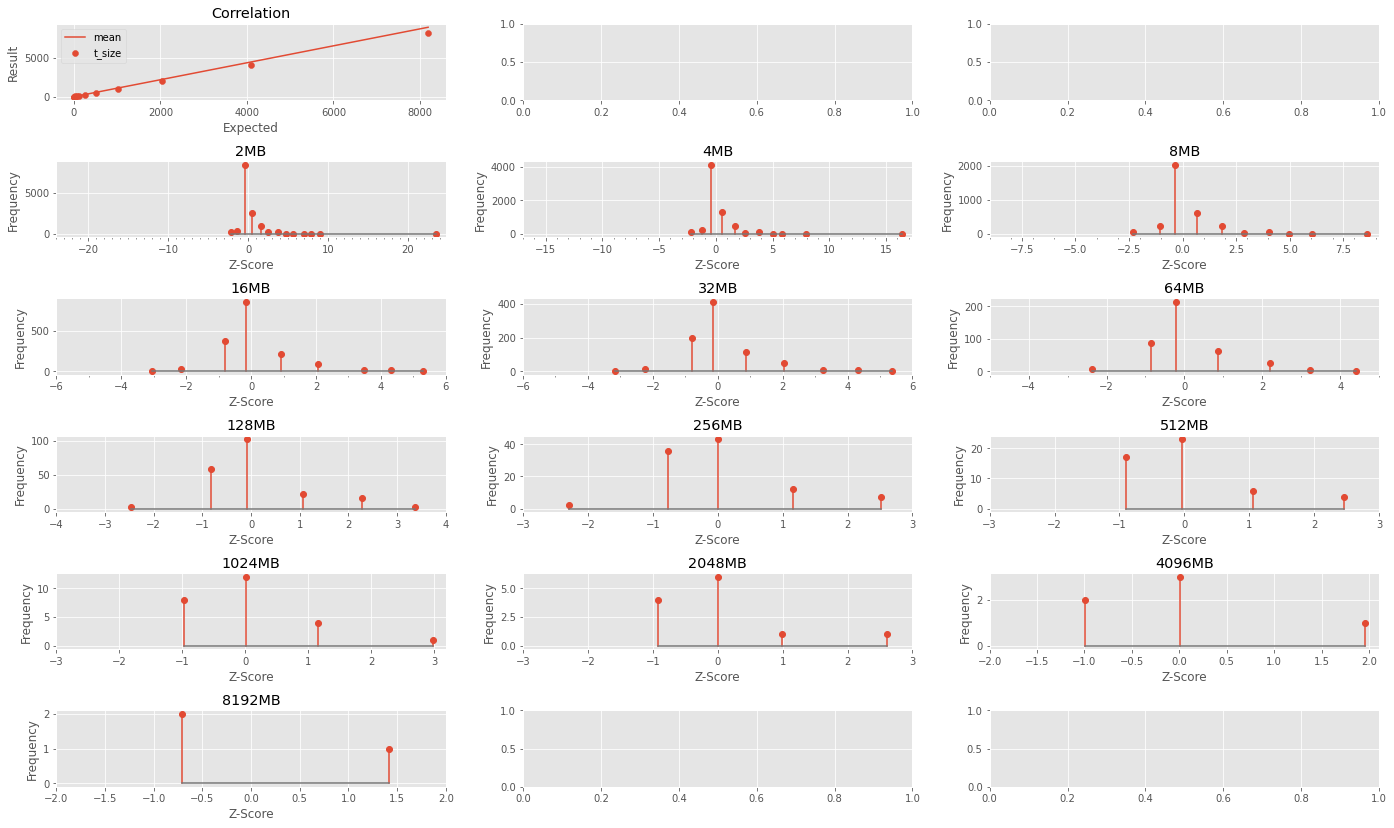

In [13]:
test(probe, minsuba)

testing maxsuba:   0%|          | 0/13 [00:00<?, ?it/s, t_size=2.1e+6]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice.
  
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  rcount = _count_reduce_items(arr, axis)
testing maxsuba: 100%|██████████| 13/13 [01:30<00:00,  6.97s/it, t_size=8.59e+9]


{
    "pearson": [
        0.9862196699679077,
        6.047212845585713e-10
    ],
    "cv": [
        {
            "size": 2,
            "cv": 0.34093586349727584
        },
        {
            "size": 4,
            "cv": 0.34245173976417403
        },
        {
            "size": 8,
            "cv": 0.33960059508305657
        },
        {
            "size": 16,
            "cv": 0.26530537412084
        },
        {
            "size": 32,
            "cv": 0.3665239332126971
        },
        {
            "size": 64,
            "cv": 0.4345711640509949
        },
        {
            "size": 128,
            "cv": 0.44144975322187835
        },
        {
            "size": 256,
            "cv": 0.6516997569341767
        },
        {
            "size": 512,
            "cv": 0.23577288472828
        },
        {
            "size": 1024,
            "cv": 0.2857119718890304
        },
        {
            "size": 2048,
            "cv": 0.21610379552922548
        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning 

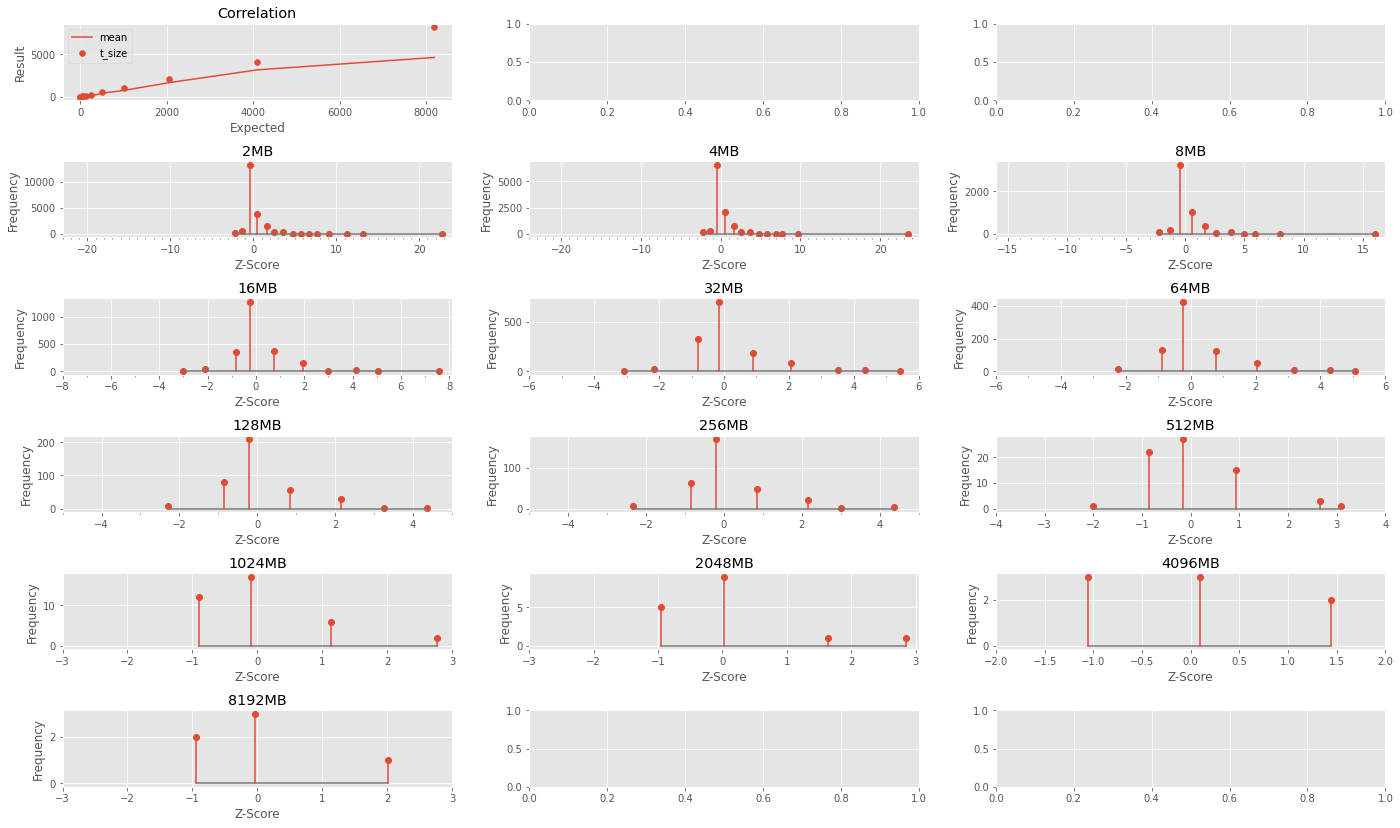

In [14]:
test(probe, maxsuba)

# Preprocessor

In [15]:
class Prerocessor:
    def __traverse__(self, parsed, keys):
        if len(keys)>1:
            return self.__traverse__(parsed[keys[0]], keys[1:])
        return parsed[keys[0]]
    def __json__(self, string):
        parsed = ujson.loads(string)
        obj = {
            key: self.__traverse__(parsed, self.keygroup[key])
            for key in self.keygroup.keys()
        }
        return obj
    def __df__(self, batch):
        json = map(self.__json__, batch)
        df   = pd.DataFrame.from_records(json, 
                                         columns=["target",
                                                  "disease",
                                                  "score"]
        )
        return df
    def __init__(self, 
                 probe,
                 keygroup):
        self.keygroup   = keygroup
        n = minsuba(probe.chunk_sizes, int(os.statvfs('/').f_bsize*1024*8))
        with tqdm(desc=f"Feature Extraction, n={n}") as tqdmo:
            with GzipFile(f"{probe.path}/{probe.filename}.{probe.extension}") as f:
                batches = partition_all(n, f)
                for batch in batches:
                    df    = self.__df__(batch)
                    df.to_hdf(
                        f"{probe.path}/{probe.filename}.hdf",
                        key='features',
                        mode='a',
                        format='table',
                        append=True
                    )
                    tqdmo.update(len(df.index))
        self.df = pd.read_hdf(
                f"{probe.path}/{probe.filename}.hdf",
                key='features'
            )


In [16]:
%timeit
data = Prerocessor(
    probe,
    {
        "target" : ["target", "id"],
        "disease": ["disease", "id"],
        "score":   ["scores", "association_score"]
    }
)

Feature Extraction, n=7190: 5784597it [06:24, 15038.65it/s]


In [17]:
!rm -rf /root/workspace/*.hdf 
!ls /root/workspace

17.12_evidence_data.json.gz


In [18]:
class CycleEnumeration:
    def hash(self):
        with tqdm(desc=f"Hashing") as tqdmo:
            def setter(x):
                tqdmo.update(1)
                return set(x.to_numpy())
            self.table = self.df.groupby('target')['disease'].apply(setter).to_numpy()
    def map(self):
        self.hash()
        combinations = itertools.combinations(range(self.table.shape[0]), 2)
        nck          = int(ncr(self.table.shape[0], 2))
        base         = int(nck/os.cpu_count())
        self.chunks  = []
        cc           = 0
        partition    = 0
        with tqdm(desc=f"Mapping") as tqdmo:
            for successive in range(base, nck, base):
                self.chunks.append(
                                {
                                    "num": cc,
                                    "len": base,
                                    "val": itertools.islice(
                                                combinations,
                                                partition,
                                                successive,
                                                1
                                            ) 
                                }
                            )
                partition  = successive
                cc        += 1
                tqdmo.update(base)
            if successive < nck:
                self.chunks.append(
                                {
                                    "num": cc,
                                    "len": nck-successive,
                                    "val": itertools.islice(
                                                combinations,
                                                successive,
                                                nck,
                                                1
                                            ) 
                                }
                            )
                tqdmo.update(base)
    def worker(self, chunk):
        local = 0
        num = chunk["num"]
        with tqdm(
            desc=f'Reducing - pool #{num}', 
            total=chunk['len'], 
            leave=True, 
            file=sys.stdout, position=0
        ) as tqdmo:
            for combination in chunk['val']:
                local += len(self.table[combination[0]] & self.table[combination[1]]) >= 2
                tqdmo.update(1)
        return local
    def reduce(self):
        with ProcessPoolExecutor() as executor:
            running_tasks = executor.map(self.worker, self.chunks)
            for running_task in running_tasks:
                self.counter += running_task
    def __init__(self, df):
        self.counter = 0
        self.df = df
        self.map()
        self.reduce()
        print(self.counter)

In [19]:
CycleEnumeration(data.df)

Hashing: 33109it [00:06, 5290.45it/s]
Mapping: 548086386it [00:00, 2657619562017.74it/s]


Reducing - pool #0: 100%|██████████| 274043193/274043193 [12:31<00:00, 364484.30it/s]
121114622


In [20]:
class CycleEnumeration2:
    def hash(self):
        with tqdm(desc=f"Hashing") as tqdmo:
            def setter(x):
                tqdmo.update(1)
                return set(x.to_numpy())
            self.table = self.df.groupby('target')['disease'].apply(setter).to_numpy()
    def map(self):
        self.hash()
        self.combinations = itertools.combinations(range(self.table.shape[0]), 2)
        self.nck          = int(ncr(self.table.shape[0], 2))
    def reduce(self):
        with tqdm(
            desc=f"Reducing", 
            iterable=range(self.nck)
        ) as tqdmo:
            for combination in self.combinations:
                self.counter += len(self.table[combination[0]] & self.table[combination[1]]) >= 2
                tqdmo.update(1)
    def __init__(self, df):
        self.counter = 0
        self.df = df
        self.map()
        self.reduce()
        print(self.counter)

In [21]:
CycleEnumeration2(data.df)

Hashing: 33109it [00:05, 5531.55it/s]
Reducing: 100%|██████████| 548086386/548086386 [15:20<00:00, 595688.11it/s]

121114622
